In [11]:
import torch
from torch import nn
from torch.nn import functional as F
import torch_geometric
from torch_geometric import nn as gnn
import networkx as nx
import matplotlib as mpl
import matplotlib.cm

# Data loading and visualization
First we'll load one of the example datasets from torch_geometric and we'll visualize the graph using networkx

In [12]:
from torch_geometric.datasets import karate

In [13]:
data = karate.KarateClub()[0]

KarateClub A toy dataset with 34 nodes representing members of a karate club and edges representing friendships.

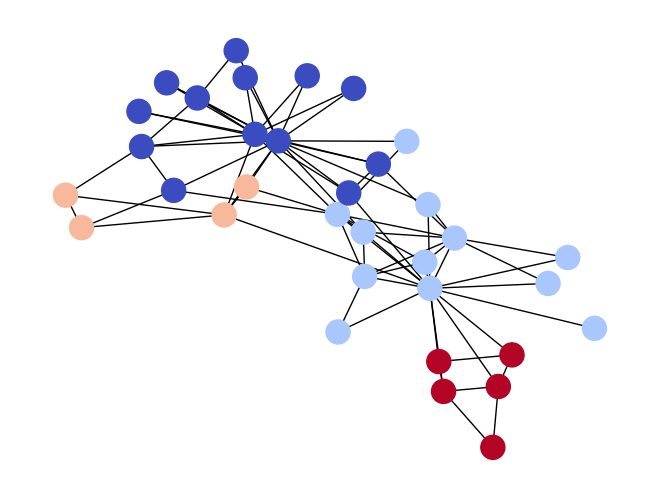

In [14]:
#Converts the PyTorch Geometric graph (data) into a networkx graph (g).
#  Ensures the graph is undirected,
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

#A dictionary mapping each node to its class label.
color_lookup = {k:data["y"].tolist()[v] for v, k in enumerate(sorted(set(g.nodes())))}

#Normalize Class Values for Coloring
# low and high: Minimum and maximum class labels (e.g., 0 and 3 for 4 classes).
low, *_, high = sorted(color_lookup.values())

#Scales class labels to a range suitable for coloring.
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)

#Specifies a color map to distinguish classes visually.
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)

#Assigns colors to nodes based on their class labels using the color map.
nx.draw(g, node_color=[mapper.to_rgba(i) 
                    for i in color_lookup.values()], )

This toy dataset contains 34 nodes belonging to 4 different classes, depicted in different colors.
Next we'll prepair the data as input for the models.
For that a dense adjacency matrix will be obtained from the sparse list of edges, and we'll load the feature matrix (the identity of each node, one hot encoded).

In [15]:
# A sparse representation of edges as pairs of connected nodes (e.g., [[0, 1], [1, 2]]).
#A value of 1 at position (i, j) indicates an edge between nodes i and j.
A = torch_geometric.utils.to_dense_adj(data["edge_index"])

#The feature matrix, where each node’s features are encoded.
X = data["x"]
print(X)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


## Part 1
The degree-normalized Laplacian matrix is defined by $L = I - D^{1/2}AD^{1/2}$, where A is the adjacency matrix, I the identity matrix, and D the degree matrix. 
Complete the implementation of the function that takes as input an adjacency matrix and returns the normalized laplacian.

In [16]:
import numpy as np

def deg_norm_laplacian(A):
    # Compute the degree matrix (D)
    degrees = np.sum(A, axis=1)  # Row sum of adjacency matrix
    D = np.diag(degrees)
    
    # Compute D^(-1/2), avoiding division by zero
    D_sqrt_inv = np.diag(1.0 / np.sqrt(degrees + 1e-8))  # Added small value to avoid division by zero
    
    # Compute the normalized Laplacian L = I - D^(-1/2) A D^(-1/2)
    I = np.eye(A.shape[0])  # Identity matrix of the same size as A
    L = I - D_sqrt_inv @ A @ D_sqrt_inv  # Matrix multiplication using @
    
    return L

## Part 2
The GCN from the lecture is defined as $H^{(l+1)} = \sigma(LWH^{(l)})$, where sigma denotes a non-linear function (e.g. ReLU), L the laplacian, weights a set of learnable weights and H the embeddings at previous layer.

Complete the implementation of the nn.Module performing such operation, without using any operator from torch_geometric

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, init_dim, embed_dim):

        super().__init__()

        # Defining a learnable weight matrix W
        self.weights = nn.Parameter(torch.randn(init_dim, embed_dim))
    
    def compute_laplacian(self, adj):

        degrees = torch.sum(adj, dim=2)  # Sum over the last dimension
        D_inv_sqrt = torch.diag_embed(1.0 / torch.sqrt(degrees + 1e-8))  # Batched diagonal matrix
        
        # Compute Laplacian L = D^(-1/2) @ A @ D^(-1/2)
        L = D_inv_sqrt @ adj @ D_inv_sqrt
        return L
    
    def forward(self, x, adj):
        
        # Compute the normalized Laplacian
        L = self.compute_laplacian(adj)  # Shape: (B, N, N)
        
        # Apply GCN layer: H^(l+1) = σ(L @ H^(l) @ W)
        x = torch.matmul(L, x)  # Shape: (B, N, init_dim)
        x = torch.matmul(x, self.weights)  # Shape: (B, N, embed_dim)
        x = F.relu(x)  # Apply non-linear activation (ReLU)
        return x


In [18]:
# Testing
gcn = GCN(34, 64)
assert gcn(X, A).shape == torch.Size([1, 34, 64]), "output does not have the right shape"

## Part 3

Using the operator from previous exercise, we implement an architecture with 2 GCN layers, a non-linearity between them and a classification head and train it to learn the karate data.

In [19]:
class GCNModel(nn.Module):
    def __init__(self, init_dim,
                 embed_dim,
                 hidden_dim, 
                num_classes = 4):
        super().__init__()
        #Your code goes here#
        self.gcn1 = GCN(init_dim, embed_dim)  # First GCN layer
        self.gcn2 = GCN(embed_dim, hidden_dim)  # Second GCN layer
        self.fc = nn.Linear(hidden_dim, num_classes)  # Fully connected layer for classification

    def forward(self, x, adj):
        #Your code goes here#
        x = self.gcn1(x, adj)  # First GCN layer
        x = F.relu(x)  # Apply ReLU non-linearity
        x = self.gcn2(x, adj)  # Second GCN layer
        x = self.fc(x)  # Classification head
        return x

model = GCNModel(34, 64, 128)
optim = torch.optim.Adam(model.parameters(), 0.01)
loss = nn.CrossEntropyLoss()

for epoch in range(200):
    # Your code goes here #
    # Predict the training instances, compute the error, backpropagate the error and update the model weights
    model.train()
    optim.zero_grad()
    
    # Forward pass
    logits = model(X, A)  # Output shape: (1, 34, 4)
    
    # Compute loss
    l = loss(logits.squeeze(0), data["y"].squeeze(0))  # Cross-entropy loss
    
    # Backpropagate
    l.backward()
    optim.step()

    if epoch%20 == 0:
        print(f"epoch {epoch}, CEL: {l.item()}")

epoch 0, CEL: 1.4699805974960327
epoch 20, CEL: 0.02929401956498623
epoch 40, CEL: 0.0023646969348192215
epoch 60, CEL: 0.0008115138625726104
epoch 80, CEL: 0.0005040090763941407
epoch 100, CEL: 0.00036795978667214513
epoch 120, CEL: 0.0002850375312846154
epoch 140, CEL: 0.00022813573013991117
epoch 160, CEL: 0.00018671188445296139
epoch 180, CEL: 0.00015556119615212083


## Part 4

Using the model from previous exercise, we adapt the dimensionality for the Cora dataset, and using the provided train_mask, test the performance attained by the model on the test nodes. The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [20]:
import torch
import numpy as np

# Create a NumPy array
arr = np.array([1, 2, 3])

# Convert to a Torch tensor
tensor = torch.from_numpy(arr)
print(tensor)


tensor([1, 2, 3])


In [21]:
cora = torch_geometric.datasets.planetoid.Planetoid(name = "cora", root = "data/")[0]

In [22]:
#feature matrix of the graph.
X = cora["x"]

#graph structure as a sparse adjacency list.
edge_index = cora["edge_index"]

#onverts the sparse edge list into a dense adjacency matrix AA
A = torch_geometric.utils.to_dense_adj(edge_index)

#create a random permutation
perm = torch.randperm(X.size(0))

#select a subset of nodes
k = 500
idx = perm[:k]

#Sets the 500500 randomly selected nodes (from idx) to False in the training mask
train_mask = torch.ones(X.shape[0]).bool()
train_mask[idx] = False

y = cora["y"]

In [30]:
model = GCNModel(1433, 64, 128, 7) # Replace by the correct model initialization
optim = torch.optim.Adam(model.parameters(), 0.01)
loss = nn.CrossEntropyLoss()
for epoch in range(101):
    model.train()
    optim.zero_grad()
    logits = model(X, A)  # Shape: (1, 2708, 7)
    train_logits = logits[:, train_mask]  # Predictions for training nodes
    train_labels = y[train_mask] # True labels for training nodes

    # Predict the instances, compute the error for the training instances using train_mask, backpropagate the error and update the model weights
    l = loss(train_logits.squeeze(0), train_labels) # Training error

    l.backward()
    optim.step()

    model.eval()
    with torch.no_grad():
        # Compute loss for test instances
        test_mask = ~train_mask  # Test mask (complement of training mask)
        test_logits = logits[:, test_mask] # Predictions for test nodes
        test_labels = y[test_mask] # True labels for test nodes
        test_l = loss(test_logits.squeeze(0), test_labels) # Test loss

    if epoch%20 == 0:
        print(f"epoch {epoch}, train CEL: {l.item()}, test CEL: {test_l.item()}")

epoch 0, train CEL: 7.625385761260986, test CEL: 7.9065728187561035
epoch 20, train CEL: 0.6634997725486755, test CEL: 0.9391465783119202
epoch 40, train CEL: 0.2517838478088379, test CEL: 0.7039656639099121
epoch 60, train CEL: 0.13919278979301453, test CEL: 0.7225289940834045
epoch 80, train CEL: 0.09064856171607971, test CEL: 0.7786988615989685
epoch 100, train CEL: 0.06307730823755264, test CEL: 0.8333649635314941


## Part 5

We Build a model using the GAT layer from PyG (torch_geometric) and test it using the same split from previous exercise. The model should take as input the sparse edge_index. (hint: the operators from torch_geometric are contained in the nn module, which was imported as gnn).

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv  # GAT layer

class GATModel(nn.Module):
    def __init__(self, init_dim, embed_dim, hidden_dim, num_classes=4):
        super().__init__()
        # Define GAT layers
        self.gat1 = GATConv(init_dim, embed_dim, heads=4, concat=True, dropout=0.6)
        self.gat2 = GATConv(embed_dim * 4, hidden_dim, heads=4, concat=True, dropout=0.6)
        self.gat3 = GATConv(hidden_dim * 4, num_classes, heads=1, concat=False, dropout=0.6)
    
    def forward(self, x, edge_index):
        # Apply first GAT layer
        x = self.gat1(x, edge_index)
        x = F.elu(x)  # Apply non-linearity
        
        # Apply second GAT layer
        x = self.gat2(x, edge_index)
        x = F.elu(x)  # Apply non-linearity

        # Apply final GAT layer for classification
        x = self.gat3(x, edge_index)
        return x


In [35]:
# Initialize the GAT model
model = GATModel(init_dim=1433, embed_dim=64, hidden_dim=128, num_classes=7)

# Optimizer and loss function
optim = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(101):
    model.train()
    optim.zero_grad()

    # Forward pass for training instances
    logits = model(cora.x, cora.edge_index)  # Use sparse edge_index
    train_logits = logits[train_mask]  # Predictions for training nodes
    train_labels = y[train_mask]  # True labels for training nodes
    l = loss_fn(train_logits, train_labels)  # Training loss

    # Backpropagation and optimization
    l.backward()
    optim.step()

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        # Compute loss for test instances
        test_mask = ~train_mask  # Complement of training mask
        test_logits = logits[test_mask]  # Predictions for test nodes
        test_labels = y[test_mask]  # True labels for test nodes
        test_l = loss_fn(test_logits, test_labels)  # Test loss

    # Print progress every 20 epochs
    if epoch % 20 == 0:
        print(f"epoch {epoch}, train CEL: {l.item():.4f}, test CEL: {test_l.item():.4f}")


epoch 0, train CEL: 1.9591, test CEL: 1.9731
epoch 20, train CEL: 0.6116, test CEL: 0.6836
epoch 40, train CEL: 0.5563, test CEL: 0.6732
epoch 60, train CEL: 0.5437, test CEL: 0.7597
epoch 80, train CEL: 0.5261, test CEL: 0.7868
epoch 100, train CEL: 0.5248, test CEL: 0.7450


## Part 6

In the previous exercise we are using a fixed learning rate of 0.01.
We Split our training data into into training and validation, and use the validation data to select the optimal learning rate in the range 0.1-0.001 and evaluate the best configuration in the test set.

In [ ]:
test_mask = ~train_mask.clone() # the test mask, do not change it
validation_mask = None # modify your code and create a validation and a training mask that are disjoint
grid = [None]
best_learning_rate = None
best_validation_loss = None
for lr in grid:
    model = None # Replace by the correct model initialization
    optim = torch.optim.Adam(model.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(101):
        model.train()
        # Predict the instances, compute the error for the training instances using train_mask, backpropagate the error and update the model weights
        l = None # Training error
        model.eval()
        with torch.no_grad():
            # compute the error for the test instances using validation_mask
            val_l = None # Test error
        if epoch%20 == 0:
            print(f"epoch {epoch}, train CEL: {l.item()}, val CEL: {val_l.item()}")
        if True:
            best_learning_rate = None
            best_validation_loss = None
model = None # Replace by the correct model initialization
optim = torch.optim.Adam(model.parameters(), best_learning_rate)
loss = nn.CrossEntropyLoss()
for epoch in range(101):
    model.train()
    # Predict the instances, compute the error for the training instances using train_mask, backpropagate the error and update the model weights
    l = None # Training error
    model.eval()
    with torch.no_grad():
        # compute the error for the test instances using test_mask
        test_l = None # Test error
    if epoch%20 == 0:
        print(f"epoch {epoch}, train CEL: {l.item()}, test CEL: {test_l.item()}")

In [36]:
test_mask = ~train_mask.clone()  # The test mask, do not change it
validation_mask = train_mask.clone()  # Create a clone of the train_mask
perm = torch.randperm(train_mask.sum())  # Random permutation of train_mask indices
num_val = int(0.2 * train_mask.sum())  # 20% of training data for validation
val_idx = perm[:num_val]  # Indices for validation nodes
validation_mask[val_idx] = True  # Mark validation nodes
train_mask[val_idx] = False  # Remove validation nodes from training

grid = [0.1, 0.01, 0.001]  # Learning rates to test
best_learning_rate = None
best_validation_loss = float('inf')

for lr in grid:
    model = GATModel(init_dim=1433, embed_dim=64, hidden_dim=128, num_classes=7)  # Initialize model
    optim = torch.optim.Adam(model.parameters(), lr)
    loss = nn.CrossEntropyLoss()

    for epoch in range(101):
        model.train()
        # Predict the instances, compute the error for the training instances using train_mask, backpropagate the error and update the model weights
        logits = model(cora.x, cora.edge_index)
        train_logits = logits[train_mask]
        train_labels = y[train_mask]
        l = loss(train_logits, train_labels)  # Training error
        l.backward()
        optim.step()

        model.eval()
        with torch.no_grad():
            # Compute the error for the validation instances using validation_mask
            val_logits = logits[validation_mask]
            val_labels = y[validation_mask]
            val_l = loss(val_logits, val_labels)  # Validation error

        if epoch % 20 == 0:
            print(f"epoch {epoch}, train CEL: {l.item()}, val CEL: {val_l.item()}")

        if val_l.item() < best_validation_loss:
            best_learning_rate = lr
            best_validation_loss = val_l.item()

model = GATModel(init_dim=1433, embed_dim=64, hidden_dim=128, num_classes=7)  # Initialize model with best learning rate
optim = torch.optim.Adam(model.parameters(), best_learning_rate)
loss = nn.CrossEntropyLoss()

for epoch in range(101):
    model.train()
    # Predict the instances, compute the error for the training instances using train_mask, backpropagate the error and update the model weights
    logits = model(cora.x, cora.edge_index)
    train_logits = logits[train_mask]
    train_labels = y[train_mask]
    l = loss(train_logits, train_labels)  # Training error
    l.backward()
    optim.step()

    model.eval()
    with torch.no_grad():
        # Compute the error for the test instances using test_mask
        test_logits = logits[test_mask]
        test_labels = y[test_mask]
        test_l = loss(test_logits, test_labels)  # Test error

    if epoch % 20 == 0:
        print(f"epoch {epoch}, train CEL: {l.item()}, test CEL: {test_l.item()}")


epoch 0, train CEL: 1.9442628622055054, val CEL: 1.9437044858932495
epoch 20, train CEL: 5886.7685546875, val CEL: 6110.37890625
epoch 40, train CEL: 10476.8115234375, val CEL: 9633.51171875
epoch 60, train CEL: 11143.5419921875, val CEL: 11231.193359375
epoch 80, train CEL: 5980.1357421875, val CEL: 5601.41650390625
epoch 100, train CEL: 7318.7734375, val CEL: 6697.02734375
epoch 0, train CEL: 1.939965009689331, val CEL: 1.940151572227478
epoch 20, train CEL: 4.613401889801025, val CEL: 4.558921813964844
epoch 40, train CEL: 37.54566955566406, val CEL: 38.90947341918945
epoch 60, train CEL: 89.99835968017578, val CEL: 93.19876098632812
epoch 80, train CEL: 146.531005859375, val CEL: 152.0286102294922
epoch 100, train CEL: 243.07931518554688, val CEL: 242.16835021972656
epoch 0, train CEL: 1.9575501680374146, val CEL: 1.9584697484970093
epoch 20, train CEL: 0.9170415997505188, val CEL: 0.8953192234039307
epoch 40, train CEL: 1.9650121927261353, val CEL: 2.040712356567383
epoch 60, trai